<h2>BMIF201 Lecture 1 in-class problem set instructions</h2>

This ungraded in-class problemset is intended to be completed in assigned groups of 2-3 in class. All members of each group should type their own solutions, but the solutions can be exactly identical. Feel free to ask other groups, the TAs, or the professor for assistance. It is OK if you do not complete it.

None of the questions should require computations that take more than a few seconds, although it's OK if they take longer. If you find yourself waiting for a solution  to run, try using smaller simulation parameters.

<h5> Problem 1 </h5>

Implement the lines `#TODO` in the code block below. Check that the assertion passes in the following code block.

In [23]:
import numpy as np

class WrightFisher:
    mu: float # symmetric mutation rate, for every site
    N: int # number of haplotypes is 2N

    # This is the function that is called when you write: model = WrightFisher(...)
    def __init__(self, mu: float, N: int):
        self.mu = mu
        self.N = N

    def next_generation(self, allele_frequencies: np.ndarray) -> np.ndarray:
        """
        :param allele_frequencies: array of allele frequencies in generation n
        :return: array of allele frequencies in generation n+1
        """

        # TODO: how many carriers before the effect of mutation?
        # use np.random.binomial(N: int or array, p: float or array)
        num_carriers_before = np.random.binomial(2*self.N, allele_frequencies)

        assert num_carriers_before.shape == allele_frequencies.shape

        # TODO: how many carriers mutate to a non-carrier?
        num_a_to_A = np.random.binomial(num_carriers_before, self.mu)

        # TODO: how many non-carriers mutate to a carrier? (use np.random.binomial again)
        num_A_to_a = np.random.binomial(2*self.N-num_carriers_before, self.mu)

        # TODO: how many carriers after the effect of mutation?
        num_carriers = num_carriers_before + num_A_to_a - num_a_to_A

        assert num_carriers.shape == allele_frequencies.shape
        assert np.all(num_carriers >= 0)
        assert np.all(num_carriers <= 2 * self.N)

        return num_carriers / (2 * self.N)

    def until_fixation(self, initial_allele_frequencies: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        :param initial_allele_frequencies: initial state
        :return: final allele frequencies (0/1-valued), time to fixation or loss
        """

        allele_frequencies = initial_allele_frequencies.copy()  # avoids modifying input array
        variants = np.where(allele_frequencies * (1-allele_frequencies) > 0)[0]  # sites not yet fixed or lost
        time_to_fixation_or_loss = np.zeros_like(allele_frequencies, dtype=int)

        generations = 0
        while len(variants) > 0:
            generations += 1
            allele_frequencies[variants] = self.next_generation(allele_frequencies[variants])
            newly_fixed_variants = (allele_frequencies[variants] * (1-allele_frequencies[variants]) == 0)
            time_to_fixation_or_loss[variants[newly_fixed_variants]] = generations
            variants = variants[~newly_fixed_variants]

        assert np.all(allele_frequencies * (1-allele_frequencies) == 0)

        return allele_frequencies, time_to_fixation_or_loss


In [24]:
num_sites = 5
model = WrightFisher(mu=1e-1, N=100)

np.random.seed(123)
generation_zero_frequency = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) 
generation_one_frequency = model.next_generation(generation_zero_frequency)
assert np.all(generation_one_frequency == np.array([0.19, 0.3, 0.355, 0.44, 0.49 ])), \
    f"Frequencies were not as expected: {generation_one_frequency}"
print("Success!")

Success!


<h5> Problem 2 </h5>

Recall that the probability of fixation for a neutral allele with starting frequency $p$ is $u(p)=p$. Using the function WrightFisher.until_fixation, verify this for the provided values of $N$ and $p$ by plotting $u(p)$ vs. $p$. A plotting script is provided.

In [27]:
num_sites = 1_000
mutation_rate = 0
population_size = 100
starting_frequency = np.arange(1,10) / 10
simulated_fixation_probability = []

model = WrightFisher(mutation_rate, population_size)
for p in starting_frequency:
    allele_frequencies = p * np.ones(num_sites)
    allele_frequencies, _ = model.until_fixation(allele_frequencies)
    simulated_fixation_probability.append(np.mean(allele_frequencies))


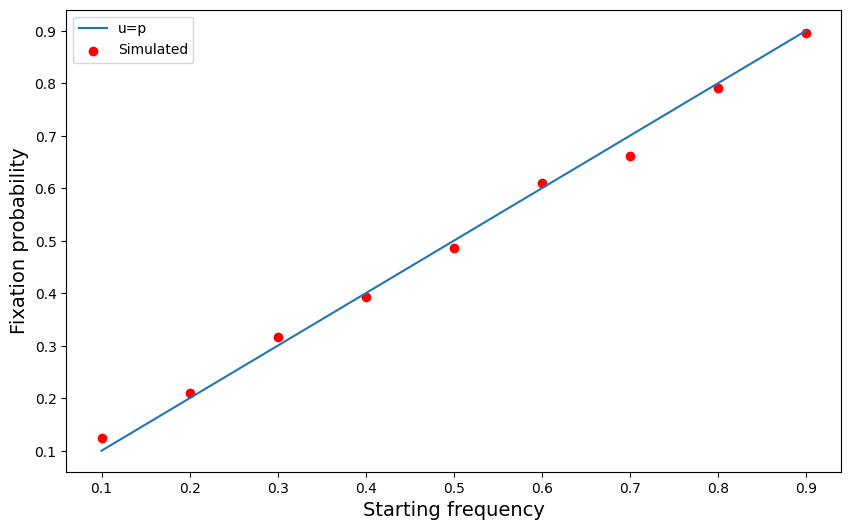

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(starting_frequency, starting_frequency)
plt.scatter(starting_frequency, simulated_fixation_probability, color="red")
plt.legend(["u=p", "Simulated"])

plt.xlabel('Starting frequency', fontsize=14)
plt.ylabel('Fixation probability', fontsize=14)
plt.show()

Recall that the time to fixation or for a rare allele is approximately $4N$ generations. Verify this for the parameters below, and plot a histogram of the fixation time. 



In [30]:
num_sites = 100_000
mutation_rate = 0
population_size = 100
starting_frequency = 1 / (2 * population_size)

model = WrightFisher(mutation_rate, population_size)
allele_frequencies, stopping_times = model.until_fixation(starting_frequency * np.ones(num_sites))
fixation_times = stopping_times[allele_frequencies == 1]

print(f"Number of fixed sites: {np.sum(allele_frequencies)}")
print(f"Mean fixation time: {np.mean(fixation_times)}")

Number of fixed sites: 487.0
Mean fixation time: 405.29979466119096


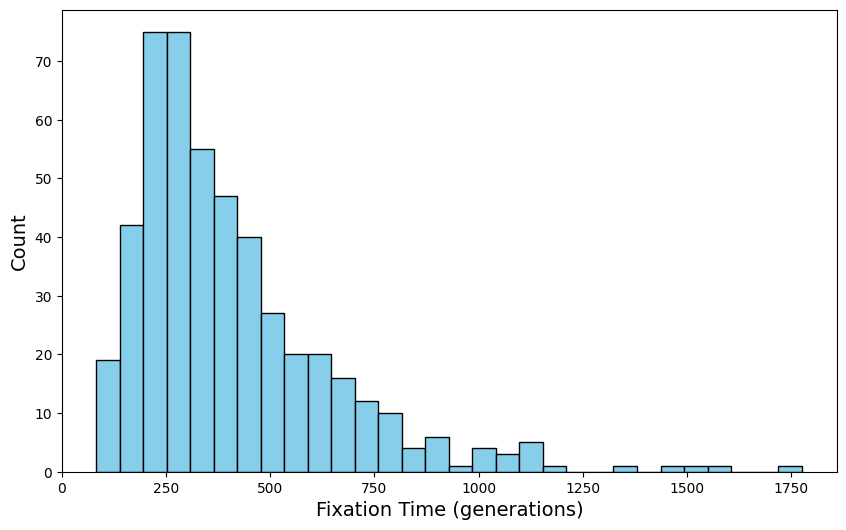

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(fixation_times, bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Fixation Time (generations)', fontsize=14)
plt.xlim(left=0)
plt.ylabel('Count', fontsize=14)

plt.show()

<h5> Problem 3 </h5>

In lecture we derived the mean heterozygosity at equilibrium:
$$E(2p(1-p))\approx 4N\mu$$
Show that with a population size of 100, the approximation is good for small $\mu$. Find the approximate value of $\mu$ at which the approximation breaks down. Hint: >N generations are required to reach equilibrium.

In [21]:
num_sites = 1_000
N = 100
mutation_rate = np.array([0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 1, 10]) / population_size
frequency = np.zeros(num_sites)
mean_heterozygosity = []
for mu in mutation_rate:
    model = WrightFisher(mu, N)
    for generations in range(10*population_size):
        frequency = model.next_generation(frequency)
    mean_heterozygosity.append(2 * np.mean(frequency * (1-frequency)))

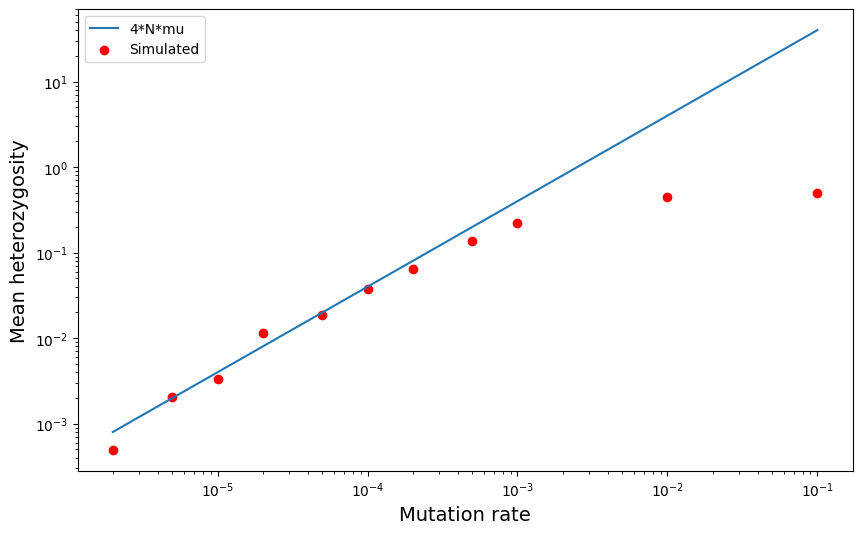

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
theta = 4 * np.asarray(mutation_rate) * N
plt.plot(mutation_rate, theta)
plt.scatter(mutation_rate, mean_heterozygosity, color="red")
plt.legend(["4*N*mu", "Simulated"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Mutation rate', fontsize=14)
plt.ylabel('Mean heterozygosity', fontsize=14)
plt.show()

<h5> Problem 4 </h5>

The number of segregating sites in a population is the number of sites at which any two individuals differ. In a large population, the number of segregating sites grows, and most are rare. Calculate the mean heterozygosity *of segregating sites*, $E(p(1-p)|0<p<1)$, in a population of size $N\in \{10, 100, 1000\}$, with $0 < \mu << 1/N$. Compare with the mean heterozygosity across all sites. Discuss with your partner: if the mean heterozygosity increases with $N$, why does the mean heterozygosity of segregating sites decrease? (Hint: see optional Problem 5 below).


In [35]:
num_sites = 10_000
mutation_rate = 0.0001 # positive number << 1 / population_size
population_size_array = [10, 100, 1000]
mean_heterozygosity_segregating_sites = {}
for population_size in population_size_array:
    starting_frequency = 1 / population_size
    num_generations = 1000
    model = WrightFisher(mutation_rate, population_size)
    
    allele_frequencies = starting_frequency * np.ones(num_sites)
    for i in range(num_generations):
        allele_frequencies = model.next_generation(allele_frequencies)
    heterozygosity = 2 * allele_frequencies * (1-allele_frequencies)
    mean_heterozygosity_segregating_sites[population_size] = np.mean(heterozygosity[heterozygosity > 0])
print(mean_heterozygosity_segregating_sites)

{10: np.float64(0.2677181208053691), 100: np.float64(0.17917546554934824), 1000: np.float64(0.1459975758136497)}


<h3>Optional problems</h3>

If you finish the problems above early, please work on the following problems with your partner. These are discussion questions, so there is no need to write down your solution; but of course, feel free to use simulations.

<h5>Problem 5</h5>

Discuss with your partner: suppose that in a population of size $N$, with $\mu<<1/N$, you sample $S<N$ haplotypes without replacement and calculate the mean heterozygosity. Will it depend upon $N$, upon $S$, or both? 

<h5>Problem 6</h5>

Discuss with your partner: as the study size $S$ increases, approximately how many segregating sites in total will be observed? What fraction of sites will be singletons? Do these quantities depend on $N$?